In [5]:
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from utils.resizer import Resizer

import matplotlib.pyplot as plt
from tqdm import tqdm

## Load Stable Diffusion

In [2]:
from ldm.util import instantiate_from_config
from omegaconf import OmegaConf

def load_model_from_config(config, ckpt, device):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cpu")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    model.to(device)
    model.eval()
    return model

In [ ]:
device = torch.device("cuda:0")
torch.cuda.set_device(0) # For multiple GPUs

config_path = "configs/stable-diffusion/v1-inference.yaml"
model_path = ""

config = OmegaConf.load(config_path)
model = load_model_from_config(config, model_path, device)

## Load image

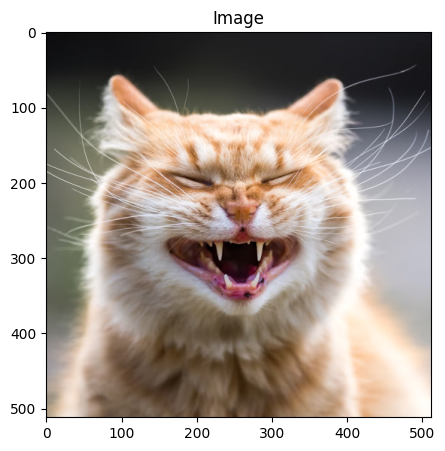

In [4]:
img_path = "../assets/thecat.jpg"

img = np.asarray(Image.open(img_path).resize((512,512)))[:,:,:3]
img = torch.from_numpy(img.copy())
img = (img.permute([2,0,1]) / 125.7 - 1).unsqueeze(0).to(device)

fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.imshow((0.5*(img+1)).clip(0,1)[0].cpu().numpy().transpose([1,2,0]))
ax.set_title("Image")
plt.show()

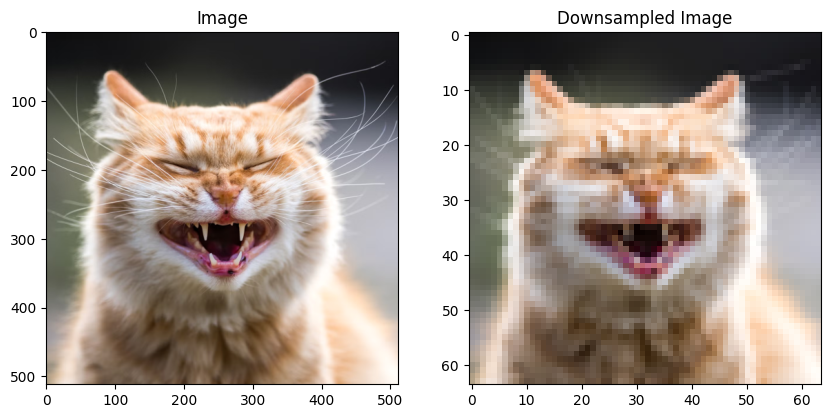

In [7]:
# Downsampling operator
down = 8
down_operator = Resizer((1,3,512,512), scale_factor=1/down).to(device)

constraint_img = down_operator(img)

fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow((0.5*(img+1)).clip(0,1)[0].cpu().numpy().transpose([1,2,0]))
ax[0].set_title("Image")
ax[1].imshow((0.5*(constraint_img+1)).clip(0,1)[0].cpu().numpy().transpose([1,2,0]))
ax[1].set_title("Downsampled Image")
plt.show()

## Inference

In [10]:
# Model forward pass
def model_pred(model, x, t, cond):
    with torch.no_grad():
        with model.ema_scope():
            t_cond = torch.tensor(x.shape[0]*[t]).view(-1).float().to(device)
            epsilon = model.model.diffusion_model(x, t_cond, context=cond)
    return epsilon


# Diffusion parameters
t = 1000
xt = torch.randn((1,4,64,64), device=device)
stride = 50
timesteps = range(t, 0, -stride)

# Inference parameters
n_steps = 10
lr = 0.1
h = 0.005

# Text caption
caption = ''
with torch.no_grad():
    cond = model.get_learned_conditioning(caption).tile(1,1,1)


# Run inference
for idx, t in tqdm(enumerate(timesteps)):
    atbar = model.alphas_cumprod[t-1].view(1,1,1,1)
    atbar_prev = model.alphas_cumprod[max(t-1-stride,1)].view(1,1,1,1)
    beta_tilde = (model.betas[t-1] * (1 - atbar_prev) / (1 - atbar)).view(1,1,1,1)

    # Compute x_0(x_t, t)
    epsilon = model_pred(model, xt, t, cond)
    x0_pred = xt / torch.sqrt(atbar) - epsilon * torch.sqrt((1-atbar)/atbar)

    for k in range(n_steps):
        # Comptue e
        xgrad = torch.zeros((1,4,64,64), device=device, requires_grad=True)
        with torch.no_grad():
            xgrad.data = x0_pred.clone()
            xgrad.grad = None
        img_pred = model.differentiable_decode_first_stage(xgrad)
        error_sr = torch.linalg.norm((constraint_img - down_operator(img_pred)))

        error_dir_sr = -torch.autograd.grad(error_sr, xgrad)[0]
        error_dir = error_dir_sr / error_dir_sr.abs().max()

        # Compute x_0(x_t + h*e, t)
        h_adaptive = h / error_dir.abs().max()
        xt_error_dir = xt + h_adaptive*error_dir
        epsilon_error_dir = model_pred(model, xt_error_dir, t, cond)
        x0_pred_error_dir = xt_error_dir / torch.sqrt(atbar) - epsilon_error_dir * torch.sqrt((1-atbar)/atbar)
        
        # Compute finite differences
        grad = (x0_pred_error_dir - x0_pred) / h_adaptive
        grad = grad / grad.abs().max()

        # Apply update
        xt = xt + lr*grad

        # Recompute x_0(x_t, t)
        epsilon = model_pred(model, xt, t, cond)
        x0_pred = xt / torch.sqrt(atbar) - epsilon * torch.sqrt((1-atbar)/atbar)


    # DDIM step
    xt = torch.sqrt(atbar_prev)*x0_pred + torch.sqrt(1-atbar_prev-beta_tilde)*epsilon + torch.sqrt(beta_tilde)*torch.randn_like(xt)


0it [00:00, ?it/s]

20it [01:20,  4.01s/it]


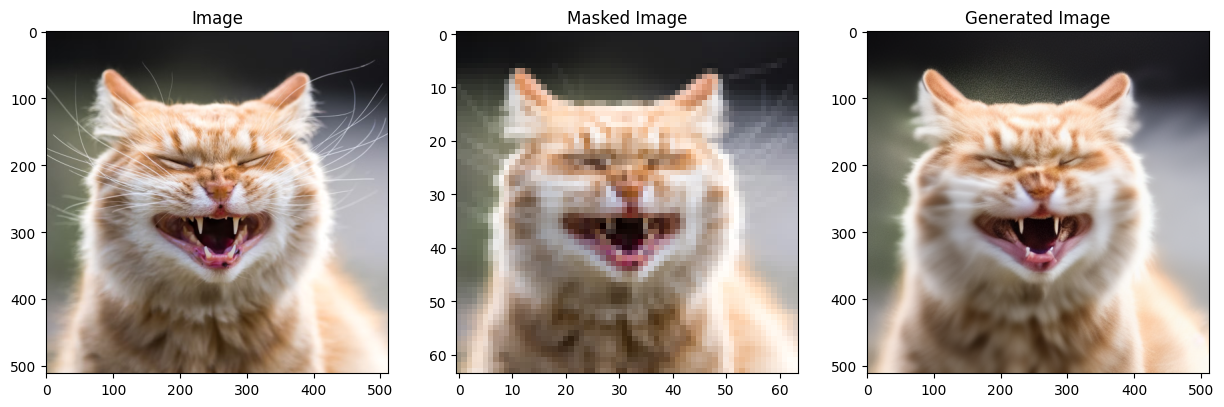

In [11]:
# Visualize result
with torch.no_grad():
    pred_img = model.decode_first_stage(x0_pred)

fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].imshow((0.5*(img+1)).clip(0,1)[0].cpu().numpy().transpose([1,2,0]))
ax[0].set_title("Image")
ax[1].imshow((0.5*(constraint_img+1)).clip(0,1)[0].cpu().numpy().transpose([1,2,0]))
ax[1].set_title("Masked Image")
ax[2].imshow((0.5*(pred_img+1)).clip(0,1)[0].cpu().numpy().transpose([1,2,0]))
ax[2].set_title("Generated Image")
plt.show()